In [95]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

In [4]:
# import file
df = pd.read_csv('Churn_Modelling.csv')

In [6]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [10]:
# check for null values
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [12]:
# Calculate the mean balance for all customers, including those with zero balance
meanbalance_withzeroes = df.Balance.mean()
print(meanbalance_withzeroes)

76485.889288


In [14]:
#  Calculate the mean balance only for customers who have a non-zero balance
meanbalance_withoutzeroes = [x for x in df.Balance if x!=0]
print(np.mean(meanbalance_withoutzeroes))

119827.49379288736


In [16]:
# adjust means
df_mean = df['Balance'].apply(lambda x: 76485.9 if x==0 else x)
df_mean.mean()

np.float64(104150.83931799998)

**Takeaways:**

**A Large Gap Between "Including Zeroes" and "Excluding Zeroes"**

  The mean jumps from 76,485.89 to 119,827.49 when zero-balance customers are removed.

  This suggests that a significant number of customers have zero balances, pulling the average down.

**Adjusted Mean Falls Between the Two**

  The adjusted mean (104,150.84) is higher than the original mean (76,485.89) but lower than the non-zero mean (119,827.49).

  This happens because we replaced all zeroes with the non-zero mean, which increases the average but still includes customers who originally had 0.

**Potential Business Insights**

High Zero-Balance Count Could Indicate Inactivity

→ Many customers don’t maintain a balance, possibly because they are inactive or low-engagement users.

Churn Risk:

→ If a majority of churned customers have zero balances, it suggests that low account usage is a strong predictor of churn.

Retention Strategy:

→ The company might need to engage customers with zero balances (e.g., incentives, personalized offers) to prevent churn.

In [18]:
# math description of dataset
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [20]:
# extract column names
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [23]:
# remove unwanted column names
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], errors='ignore', inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [25]:
# extract country names
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Geography
France     311.332479
Germany    300.402861
Spain      153.123552
Name: Balance (in millions), dtype: float64


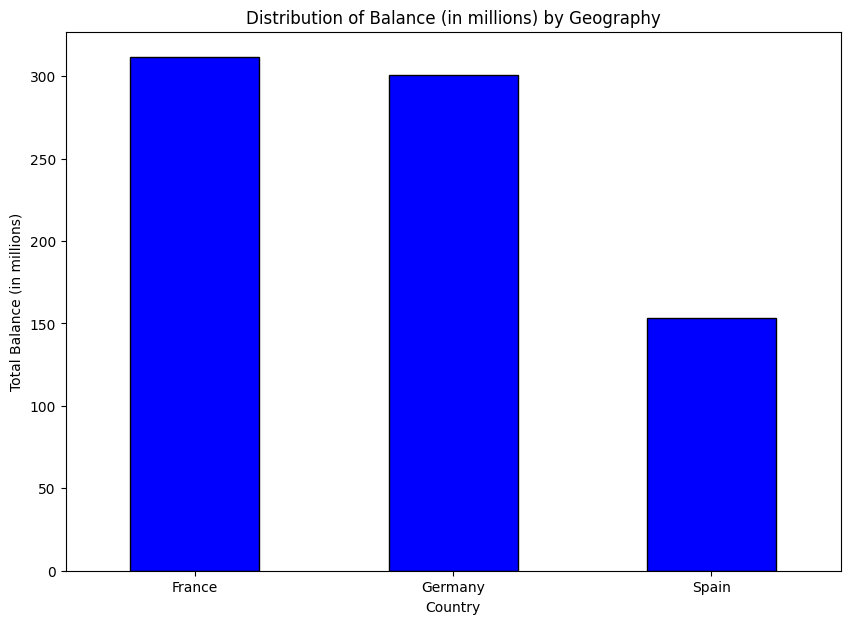

In [28]:
# plot relationship between balance and country
nations = df.groupby("Geography")["Balance"].sum() / 1_000_000
nations = nations.rename("Balance (in millions)")
print(nations)

plt.figure(figsize=(10,7))
nations.plot(kind="bar", color="blue", edgecolor="black")
plt.title("Distribution of Balance (in millions) by Geography")
plt.ylabel("Total Balance (in millions)")
plt.xlabel("Country")
plt.xticks(rotation=0)
plt.show()

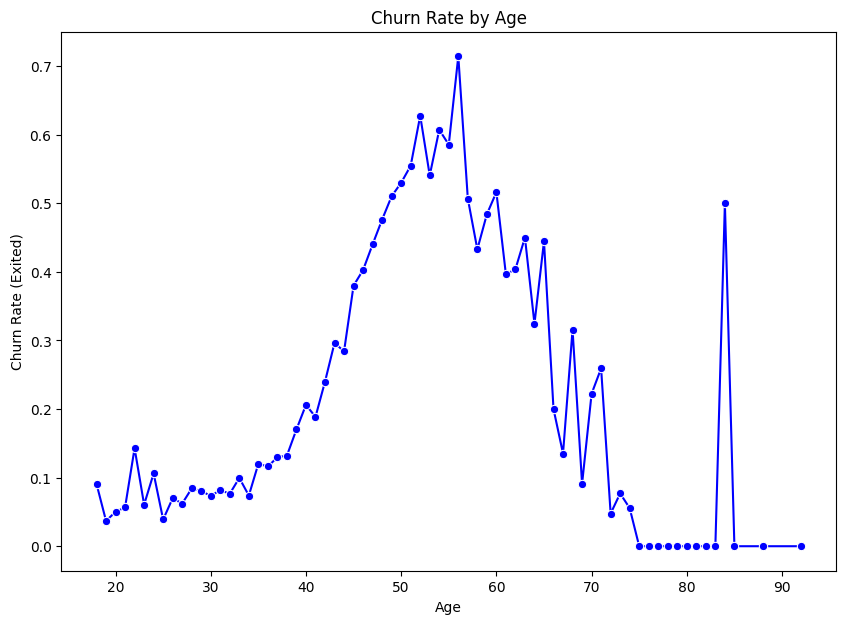

In [87]:
# calculate churn rate and plot relationship with age
import seaborn as sns
age_churn = df.groupby("Age")["Exited"].mean()
plt.figure(figsize=(10,7))
sns.lineplot(x=age_churn.index, y=age_churn.values, marker="o", color="b")
plt.title("Churn Rate by Age")
plt.xlabel("Age")
plt.ylabel("Churn Rate (Exited)")
plt.show()

<ipython-input-91-27602cad3b6b>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_churn = df.groupby("BalanceBin")["Exited"].mean()


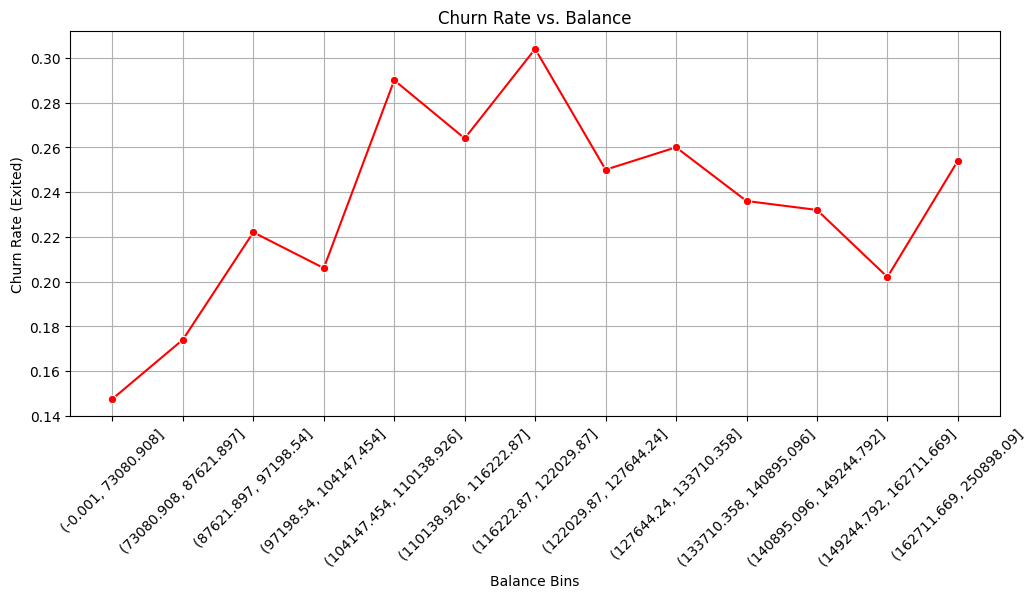

In [91]:
# Group by Balance (binning into intervals for smoother visualization)
df["BalanceBin"] = pd.qcut(df["Balance"], q=20, duplicates='drop')  # Dividing balance into 20 quantile-based bins
balance_churn = df.groupby("BalanceBin")["Exited"].mean()

# Plot the line chart
plt.figure(figsize=(12, 5))
sns.lineplot(x=range(len(balance_churn)), y=balance_churn.values, marker="o", color="r")

# Labels and title
plt.xlabel("Balance Bins")
plt.ylabel("Churn Rate (Exited)")
plt.title("Churn Rate vs. Balance")
plt.xticks(ticks=range(len(balance_churn)), labels=balance_churn.index, rotation=45)
plt.grid(True)

# Show the plot
plt.show()

<Figure size 600x600 with 0 Axes>

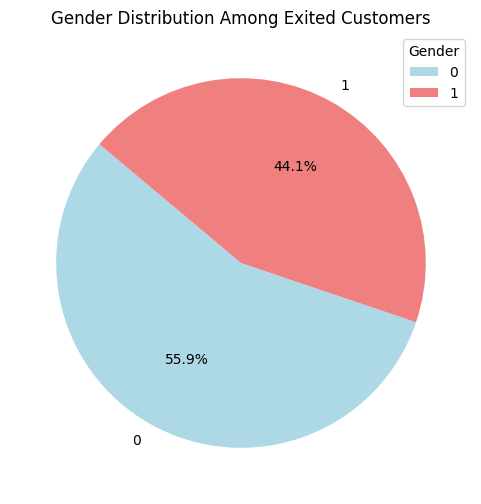

In [94]:
# Filter dataset for exited customers
exited_df = df[df["Exited"] == 1]

# Count the number of exited customers by gender
gender_counts = exited_df["Gender"].value_counts()

# Plot the pie chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    gender_counts, labels=gender_counts.index, autopct="%1.1f%%",
    colors=["lightblue", "lightcoral"], startangle=140
)

# Add legend
plt.legend(wedges, gender_counts.index, title="Gender", loc="best")

plt.title("Gender Distribution Among Exited Customers")

# Show the plot
plt.show()

In [30]:
# convert geography to numerical data
label_encoder = LabelEncoder()
df['Geography'] = label_encoder.fit_transform(df['Geography'])

In [32]:
df['Geography']

,Geography
0,0
1,2
2,0
3,0
4,2
...,...
9995,0
9996,0
9997,0
9998,1


In [34]:
# convert gender to numerical data
df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [36]:
df['Gender']

,Gender
0,0
1,0
2,0
3,0
4,0
...,...
9995,1
9996,1
9997,0
9998,1


In [38]:
# check data types of columns
df.dtypes

,0
CreditScore,int64
Geography,int64
Gender,int64
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64
HasCrCard,int64
IsActiveMember,int64
EstimatedSalary,float64


In [40]:
# calculater correlation matrix
corr_matrix = df.corr()
corr_matrix

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,0.007888,-0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Geography,0.007888,1.000000,0.004719,0.022812,0.003739,0.069408,0.003972,-0.008523,0.006724,-0.001369,0.035943
Gender,-0.002857,0.004719,1.000000,-0.027544,0.014733,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.106512
Age,-0.003965,0.022812,-0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,0.003739,0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.069408,0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,0.003972,-0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.008523,0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.006724,0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.001369,-0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


In [42]:
# extract the features in the descending order of their correlation to target variable (Exited)
high_corr_features = corr_matrix["Exited"].sort_values(ascending=False)
print("\nCorrelation with target variable (Exited):")
high_corr_features


Correlation with target variable (Exited):


,Exited
Exited,1.000000
Age,0.285323
Balance,0.118533
Geography,0.035943
EstimatedSalary,0.012097
HasCrCard,-0.007138
Tenure,-0.014001
CreditScore,-0.027094
NumOfProducts,-0.047820
Gender,-0.106512


In [44]:
# separate features (x) and target (y)
x = df.drop(columns=['Exited'])
y = df['Exited']

In [46]:
print('X_Shape: ', x.shape, '\n', 20*'-', '\n', 'Y_Shape', y.shape)

X_Shape:  (10000, 10) 
 -------------------- 
 Y_Shape (10000,)


In [48]:
# split dataset into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

In [52]:
x_train.shape

(8000, 10)

In [54]:
y_train.shape

(8000,)

In [56]:
x_test.shape

(2000, 10)

In [58]:
y_test.shape

(2000,)

In [60]:
# random forest
RFC = RandomForestClassifier()
RFC.fit(x_train, y_train)

RandomForestClassifier()

In [62]:
RFC_accuracy = RFC.score(x_test, y_test)
print('Accuracy: ', RFC_accuracy*100)

Accuracy:  86.4


In [64]:
RFC.score(x_train, y_train)

0.999875

In [69]:
pred_RFC = RFC.predict(x_test)
pred_RFC

array([0, 0, 0, ..., 1, 0, 0])

In [71]:
RFC_accuracy1 = accuracy_score(y_test, pred_RFC)
print("Accuracy: ", RFC_accuracy1*100, '%')

Accuracy:  86.4 %


In [73]:
# Logistic Regression
LR = LogisticRegression()
LR.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [75]:
LR_accuracy = LR.score(x_test, y_test)
print("Accuracy: ", LR_accuracy*100, '%')

Accuracy:  79.9 %


In [77]:
LR.score(x_train, y_train)

0.789625

In [79]:
pred_LR = LR.predict(x_test)
pred_LR

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
LR_accuracy1 = accuracy_score(y_test, pred_LR)
print("Accuracy: ", LR_accuracy1*100, '%')

Accuracy:  79.9 %


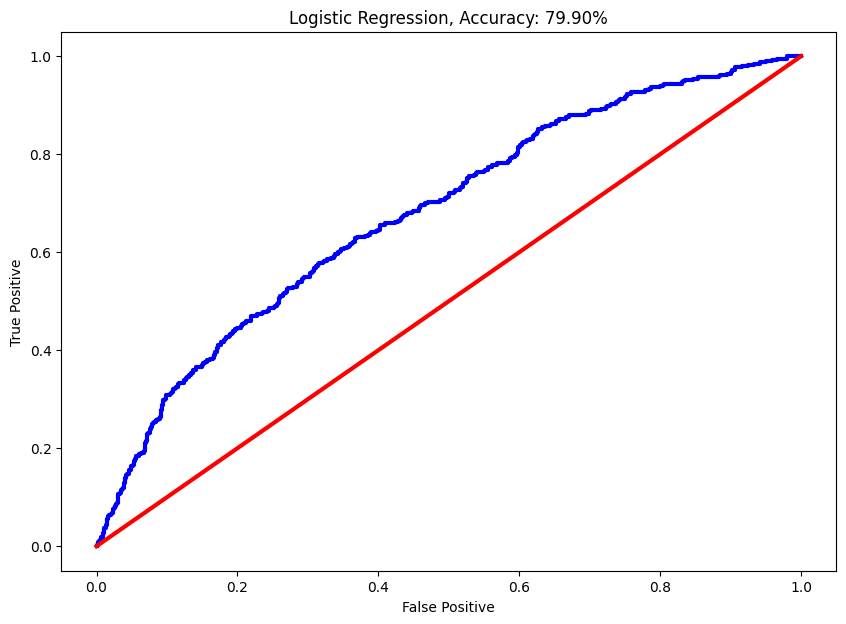

In [84]:
# plot accuracy of Logistic Regression
prob_LR = LR.predict_proba(x_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, prob_LR)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,color='blue', lw=3)
plt.plot([0,1],[0,1],color='red',lw=3)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title(f'Logistic Regression, Accuracy: {LR_accuracy*100:.2f}%')
plt.show()

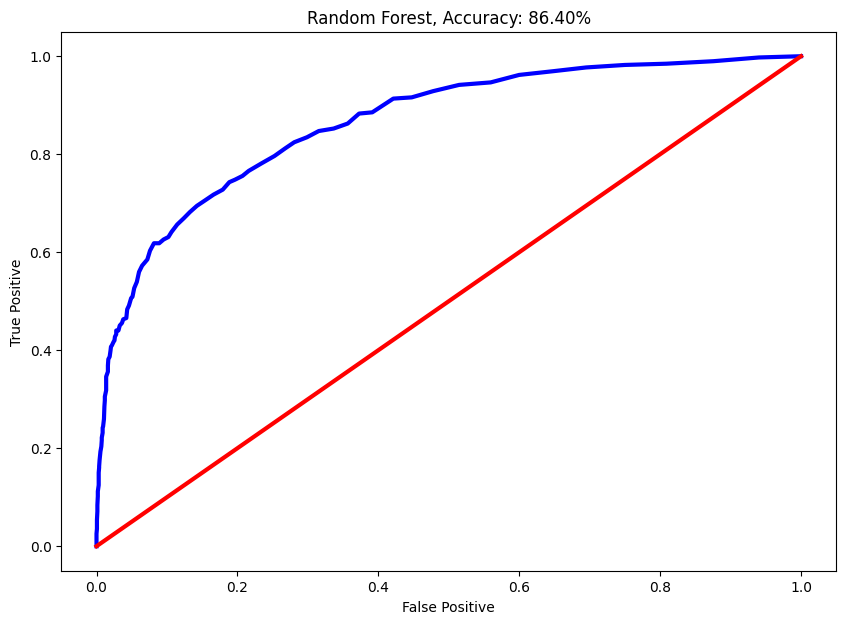

In [85]:
# plot accuracy of Random Forest
prob_RFC = RFC.predict_proba(x_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, prob_RFC)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,color='blue', lw=3)
plt.plot([0,1],[0,1],color='red',lw=3)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title(f'Random Forest, Accuracy: {RFC_accuracy*100:.2f}%')
plt.show()